# Sistema de Recomendacion de Libros Basado en Contenido

##### Audiencia y motivacion

Como un acérrimo lector siempre me encuentro en la busqueda de nuevos titulos para leer y recomendando a amigos y conocidos sus posibles nuevas lecturas. 
En ambos casos es comun que se presente la misma problematica: es muy dificil poder dar con lo que busco, generalmente por falta de conocimiento sobre nuevos lanzamientos o libros no tan nuevos pero que fueron escritos por autores que aún no tuve la oportunidad de conocer. Por esto, apenas descubri el dataset con el que estoy trabajando se me ocurrio hacer un sistema de recomendacion de libros basado en las caracteristicas principales que tenga un libro que me haya gustado leer (content-based filtering).

---

##### Descripcion Del DataFrame

Best Books Ever es un data set extraido de la pagina GoodReads en donde los usuarios (entre otras cosas) pueden calificar los libros que hayan leido, este dataset recopila todas las puntuaciones para cada libro ademas de agregar informacion de los mismos como el genero al que pertenecen, la fecha de publicacion o el formato en el que fue publicado el libro.
Las columnas con las que cuento son:


| Columna | Descripcion |
| -------------- | ------------- |
| bookId | ID del libro como en goodreads.com |
| title | Titulo |
| author | Autor/a |
| rating | Calificacion global en goodreads |
| language | Idioma |
| genres | Lista de generos | 
| bookFormat | Tipo de encuadernado |
| pages | Cantidad de paginas |
| publishDate | Fecha de publicacion |
| firstPublishDate | Fecha de publicacion de la primer edicion |
| numRatings | Cantidad de calificaciones |
| likedPercent | Porcentaje de calificaciones mayores a dos estrellas |
| price | Precio |
| publishDecade | Decada de publicacion |
| weightedRating | Rating aplicando shrinkage estimation |


---

##### Preguntas Problema

El objetivo principal de este trabajo es crear un modelo de recomendaciones basado en contenido, por esto, lo mas importante a la hora de analizar los datos es:

- Reconocer cuales son las caracteristicas principales de los libros
    - Ver sus distribuciones generales
    - Ver como estan relacionadas

Una vez encontrada la respuesta a estos items voy a contar con la informacion necesaria para saber que partes del dataframe son relevantes para el desarrollo de mi modelo.

---

##### Cargando el DataFrame

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('BestBooksDS.csv', index_col=0)

---

##### EDA

con el dataframe ya cargado, puedo seguir con el proceso de analisis de los datos.

In [4]:
df.head()

,bookId,title,author,rating,language,genres,bookFormat,pages,publishDate,firstPublishDate,numRatings,likedPercent,price,publishDecade,weightedRating
0,2767052-the-hunger-games,The Hunger Games,Suzanne Collins,4.33,English,"['Young Adult', 'Fiction', 'Dystopia', 'Fantas...",hardcover,374,2008-09-14,NaN,6376780,96.0,5.09,2000,4.329518
1,2.Harry_Potter_and_the_Order_of_the_Phoenix,Harry Potter and the Order of the Phoenix,"J.K. Rowling, Mary GrandPré (Illustrator)",4.50,English,"['Fantasy', 'Young Adult', 'Fiction', 'Magic',...",paperback,870,2004-09-28,2003-06-21,2507623,98.0,7.38,2000,4.498101
2,2657.To_Kill_a_Mockingbird,To Kill a Mockingbird,Harper Lee,4.28,English,"['Classics', 'Fiction', 'Historical Fiction', ...",paperback,324,2006-05-23,2060-07-11,4501075,95.0,5.62,2000,4.279428
3,1885.Pride_and_Prejudice,Pride and Prejudice,"Jane Austen, Anna Quindlen (Introduction)",4.26,English,"['Classics', 'Fiction', 'Romance', 'Historical...",paperback,279,2000-10-10,2013-01-28,2998241,94.0,3.86,2000,4.259208
4,41865.Twilight,Twilight,Stephenie Meyer,3.60,English,"['Young Adult', 'Fantasy', 'Romance', 'Vampire...",paperback,501,2006-09-06,2005-10-05,4964519,78.0,2.10,2000,3.600848


In [13]:
# Veo el tamaño del dataframe y el formato de las columnas

print(f'El DataFrame contiene {df.shape[0]} filas y {df.shape[1]} columnas')

El DataFrame contiene 52429 filas y 15 columnas


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52429 entries, 0 to 52477
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   bookId            52429 non-null  object 
 1   title             52429 non-null  object 
 2   author            52429 non-null  object 
 3   rating            52429 non-null  float64
 4   language          52429 non-null  object 
 5   genres            52429 non-null  object 
 6   bookFormat        52429 non-null  object 
 7   pages             52429 non-null  int64  
 8   publishDate       50645 non-null  object 
 9   firstPublishDate  31109 non-null  object 
 10  numRatings        52429 non-null  int64  
 11  likedPercent      52429 non-null  float64
 12  price             52429 non-null  float64
 13  publishDecade     52429 non-null  int64  
 14  weightedRating    52429 non-null  float64
dtypes: float64(4), int64(3), object(8)
memory usage: 6.4+ MB


Para decidir cuales son las caracteristicas principales de mi DataFrame, es necesario tener en claro el objetivo de mi modelo. 

El conten-based filtering utiliza las caracteristicas de cada producto para predecir y recomendar al usuario productos nuevos pero similares. Por esto, creo que lo mas importante a la hora de seleccionar estas caracteristicas es solo tener en cuenta las columnas que engloben informacion mas general de cada libro, ya que de ahi puedo establecer relaciones con el resto. Por ejemplo, las columnas de cantidad de votos ('numRatings') y la de precios ('price') contienen informacion demasiado especifica de cada libro y que no aporta nada a la descripcion del mismo, ya que por ejemplo, el que varios libros tengan un precio similar no los convierte en parecidos. Por esto, las columnas de rating, language, bookFormat, pages, likedPercent, price y weightedRating quedan descartadas como columnas principales.

Las columnas mas relevantes a simple vista son principalmente la de genres ya que es la que mas describe las caracteristicas de cada libro, luego, la columna author es relevante ya que si a una persona le gusta un libro, es probable que le interese leer mas obras del mismo autor o en el caso de sagas leer los siguentes tomos. Por ultimo, creo que es relevante agrupar los libros por fecha de salida, ya que los generos van evolucionando con el tiempo, entonces puede ser que a un usuario fanatico de un genero actual no le agraden libros pertenecientes a los origenes de ese genero o viceversa. Se cuentan con 3 columnas que hacen referencia a la fecha de lanzamiento de cada libro, siendo publishDate y firstPublishDate indicativos de como su nombre indica de la fecha de publicacion de este, aunque es una fecha muy especifica para el uso que se le quiere dar. Por esto, seleccioné la columna publishDecade que contiene informacion sobre la fecha de publicacion pero de manera mas general, permitiendo asi una agrupacion mas sencilla de los libros.

Por ultimo, la columna title, aunque no vaya a ser utilizada en el modelo es muy importante ya que es la forma normalmente utilizada para identificar a un libro. La columna bookId queda descartada ya que no va a ser utilizada como indice y no contiene informacion relevante.

#### Exploro las variables que seran utilizadas en el modelo
##### Autores ('author')

In [5]:
# Variable autores
# Veo la cantidad de autores
autores = df['author'].value_counts()

print(f'Hay un total de {len(autores)} autores')

Hay un total de 28227 autores


In [8]:
# Veo los autores con mas libros publicados

print(autores[:10])

Nora Roberts (Goodreads Author)       86
Agatha Christie                       72
Stephen King (Goodreads Author)       66
Erin Hunter                           59
Bella Forrest (Goodreads Author)      53
Meg Cabot (Goodreads Author)          52
Lucian Bane (Goodreads Author)        49
Terry Pratchett                       48
Karen Kingsbury (Goodreads Author)    48
Bonnie Bryant                         47
Name: author, dtype: int64


C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10712\2554949321.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  autores_populares = df.groupby('author').sum().nlargest(5, columns='numRatings')


Text(0.5, 1.0, 'Autores populares segun la cantidad de ratings de sus libros')

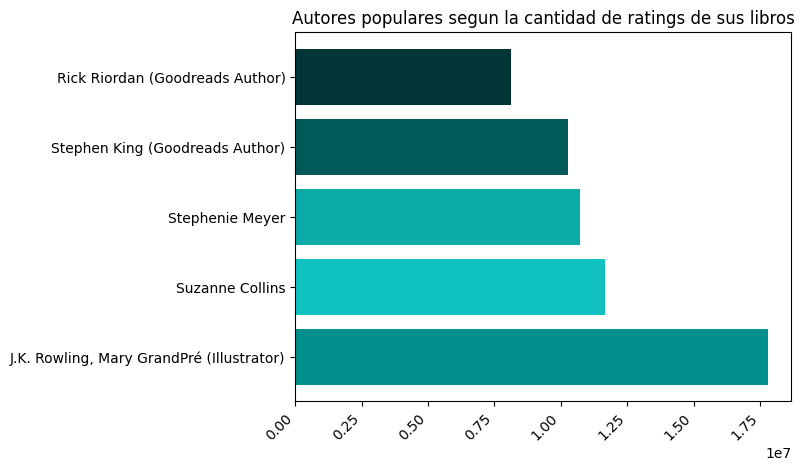

In [8]:
#Autores populares
#agrupo el dataframe por autor y sumo la cantidad de votos que tienen sus libros
autores_populares = df.groupby('author').sum().nlargest(5, columns='numRatings')

plt.barh(y=autores_populares.index, width=autores_populares['numRatings'], color={'#0FC2C0', '#0CABA8', '#008F8C', '#015958', '#023535'})
plt.xticks(rotation=45, ha='right')
plt.title('Autores populares segun la cantidad de ratings de sus libros')

##### Generos ('genres')

In [13]:
import ast
import itertools

#Concateno todas las listas de generos para poder ver cuales son los generos mas populares
genres = list()
for i in range(len(df)):

    lista = ast.literal_eval(df.iloc[i]['genres'])
    genres.append(lista)

genres = pd.Series(itertools.chain.from_iterable(genres))

In [14]:
generos_populares = genres.value_counts()[:5]

print(f'Hay un total de {len(genres.value_counts())} generos')

Hay un total de 982 generos


Text(0.5, 1.0, 'Generos populares segun cantidad de libros pertenecientes a cada genero')

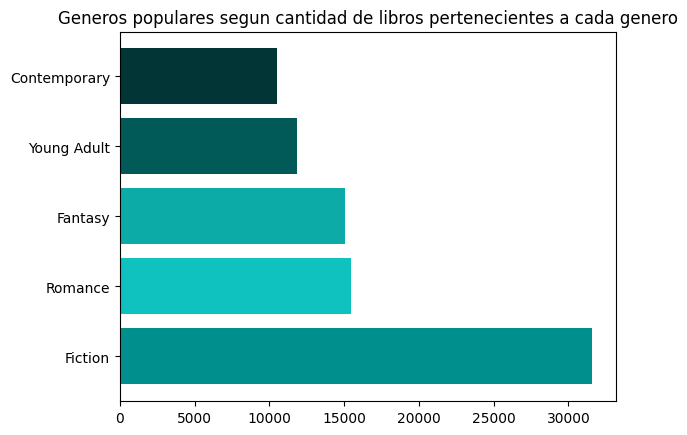

In [15]:
# veo la cantidad de libros publicados pertenecientes a los 5 generos mas populares

plt.barh(y=generos_populares.index, width=generos_populares.values, color={'#0FC2C0', '#0CABA8', '#008F8C', '#015958', '#023535'})
plt.title('Generos populares segun cantidad de libros pertenecientes a cada genero')

##### Decada de publicacion ('publishDecade')

In [6]:
print('Cantidad de libros publicados por decada')
df.publishDecade.value_counts()

Cantidad de libros publicados por decada


2010    22531
2000    20261
1990     6095
1980     1883
1970      767
2020      410
1960      291
1950       98
1940       27
1930       24
1920       19
1900        9
1910        5
1880        4
1890        2
2050        1
1870        1
1820        1
Name: publishDecade, dtype: int64

(array([1.0000e+00, 0.0000e+00, 5.0000e+00, 1.6000e+01, 4.3000e+01,
        1.2500e+02, 2.9410e+03, 2.6356e+04, 2.2941e+04, 1.0000e+00]),
 array([1820., 1843., 1866., 1889., 1912., 1935., 1958., 1981., 2004.,
        2027., 2050.]),
 <BarContainer object of 10 artists>)

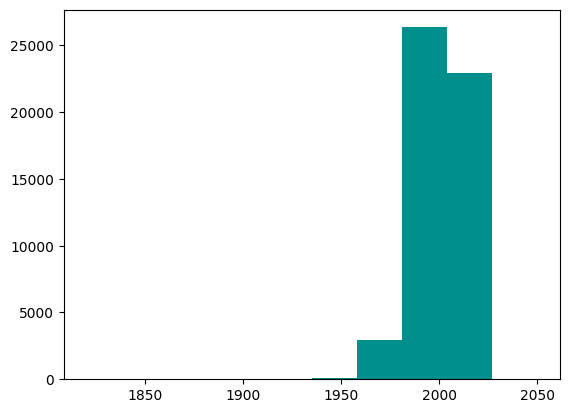

In [20]:
# Hago un histograma de la cantidad de libros publicados en cada decada, aunque como es de esperar por la lista anterior
# Hay 2 decadas que tienen una cantidad muy alta de publicaciones y entonces no se llegan a apreciar el resto de decadas
# que tienen una cantidad mucho menor (o casi nula).

plt.hist(df.publishDecade, color={'#008F8C'})

##### Relaciones entre estas variables

In [17]:
# Agrupo el dataframe por decada
grouped = df.groupby(['publishDecade'])
# Creo el DataFrame a devolver
autores_decada = pd.DataFrame()

#sumo la cantidad de votos de cada autor y selecciono el mas votado de cada decada
for name, group in grouped:
    autores_populares = group.groupby(['author']).agg({'numRatings': 'sum'}).sort_values(by='numRatings', ascending=False)
    autores_decada = pd.concat([autores_decada, autores_populares.head(1)])


autores_decada['decade'] = [int(name) for name, group in grouped]
autores_decada[:-1].style.set_caption('Autor mas popular de cada decada')

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10712\1248519905.py:7: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10712\1248519905.py:12: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  autores_decada['decade'] = [int(name) for name, group in grouped]


,numRatings,decade
author,,
"Mir Taqi Mir, William Carmichael Smyth, Esq. (Editor)",5,1820
Friedrich Nietzsche,1089,1870
"Nellie Bly, Karine Ribeiro (Translator)",12358,1880
Charles Reade,313,1890
L. Frank Baum,22247,1900
Jean Webster,46466,1910
Ernest Hemingway,377031,1920
"Jean-Paul Sartre, Lloyd Alexander (Translator), H.P. van den Aardweg (Translator), Hayden Carruth (Introduction)",86235,1930
"Walter Farley, Keith Ward (Illustrator)",69436,1940


In [22]:
#libro mas vendido de cada decada
libros_decada = pd.DataFrame()

for name, group in grouped:
  libros_decada = libros_decada.append(group.nlargest(1, 'numRatings')[['title', 'author', 'numRatings', 'publishDecade']])

libros_decada['publishDecade'] = libros_decada['publishDecade'].astype(int)
libros_decada[:-1].style.set_caption('Libro mas popular de cada decada')

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10712\2717580530.py:4: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in grouped:
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10712\2717580530.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  libros_decada = libros_decada.append(group.nlargest(1, 'numRatings')[['title', 'author', 'numRatings', 'publishDecade']])
C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10712\2717580530.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  libros_decada = libros_decada.append(group.nlargest(1, 'numRatings')[['title', 'author', 'numRatings', 'publishDecade']])
C:\Users\Nicolas\AppData\Local

,title,author,numRatings,publishDecade
34941,شعلۂ عشق,"Mir Taqi Mir, William Carmichael Smyth, Esq. (Editor)",5,1820
22824,On Truth and Lies in a Nonmoral Sense,Friedrich Nietzsche,1089,1870
29827,Ten Days in a Mad-House,"Nellie Bly, Karine Ribeiro (Translator)",12358,1880
18937,The Cloister and the Hearth,Charles Reade,313,1890
9291,Ozma of Oz,L. Frank Baum,22247,1900
1666,Daddy-Long-Legs,Jean Webster,46466,1910
218,The Sun Also Rises,Ernest Hemingway,365874,1920
779,Nausea,"Jean-Paul Sartre, Lloyd Alexander (Translator), H.P. van den Aardweg (Translator), Hayden Carruth (Introduction)",86235,1930
2216,The Black Stallion,"Walter Farley, Keith Ward (Illustrator)",69436,1940
421,A Streetcar Named Desire,Tennessee Williams,261257,1950


El analisis realizado se centra en las variables Autor, Generos y Decada de Publicacion aunque aveces usando otras variables ya que estas son las variables que voy a utilizar para crear el modelo de recomendaciones.
Ademas, no es un analisis muy profundo ya que solo se intentan ver las distribuciones de los componentes principales y ver cuales son las caracteristicas mas repetidas dentro de cada uno porque luego estas serán utilizadas para calcular las relaciones entre cada libro.

---

### Feature Engineering


Proceso y preparo las variables anteriormente exploradas para su utilizacion en el modelo

In [3]:
# creo una copia del dataframe original
metadata = df.copy()

In [4]:
from ast import literal_eval

features = ['author', 'genres']

metadata['genres'] = metadata['genres'].apply(literal_eval)

In [5]:
# funcion que elimina los espacios, transforma a minuscula y en el caso de strings que contengan una coma, elimina todo el texto a partir de esta.
def cleaner(x):
    if isinstance(x, list):
        return [str.lower(i.replace(" ", "")) for i in x]
    else:
        if isinstance(x, str):
            return str.lower(x.replace(" ", "").split(",")[0])
        else:
            return ''

In [6]:
# limpio las columnas 'author' y 'genres' con la funcion que acabo de crear
for feature in features:
    metadata[f'{feature}Clean'] = metadata[feature].apply(cleaner)

In [7]:
# funcion que devuelve un string concatenando las columnas 'author', 'publishDecade' y 'genres' del dataset utilizado con un espacio.
def make_soup(x):
    return ''.join(x['authorClean']) + ' '  +  ''.join(str(x['publishDecade'])) + ' ' + ' '.join(x['genresClean'])

In [8]:
# guardo la informacion devuelta por la funcion 'make_soup' en una nueva columna 'soup' del dataset
metadata['soup'] = metadata.apply(make_soup, axis=1)

In [9]:
#asi se ven estos resultados
metadata['soup'].head()

0    suzannecollins 2000 youngadult fiction dystopi...
1    j.k.rowling 2000 fantasy youngadult fiction ma...
2    harperlee 2000 classics fiction historicalfict...
3    janeausten 2000 classics fiction romance histo...
4    stepheniemeyer 2000 youngadult fantasy romance...
Name: soup, dtype: object

In [10]:
# Una vez creada la variable soup elimino las variables que no voy a utilizar

metadata.drop(columns=['bookId', 'rating', 'language', 'genres', 'bookFormat', 'pages', 'publishDate', 'firstPublishDate', 'numRatings', 'likedPercent', 'price', 'authorClean', 'genresClean'], inplace=True)

In [11]:
# Creo una variable llamada 'filtro' para usar luego en el filtro de seleccion para el modelo
def make_filtro(metadata):
    return ''.join(metadata['title']) + '-' + ''.join(metadata['author'])

In [12]:
# Limpio la variable 'author' antes de aplicar la funcion creada
# Esto está pensado para eliminar cosas como el termino '(goodreads author)' que aparece al lado del nombre de muchos autores

for i in range(len(metadata)):
    metadata['author'].iloc[i] = metadata['author'].iloc[i].split('(')[0]

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_10928\2216697312.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata['author'].iloc[i] = metadata['author'].iloc[i].split('(')[0]


In [13]:
# Aplico la funcion creada

metadata['filtro'] = metadata.apply(make_filtro, axis=1)

In [14]:
# Estos son los resultados que se guardaron en la columna filtro

metadata.filtro.head()

0                     The Hunger Games-Suzanne Collins
1    Harry Potter and the Order of the Phoenix-J.K....
2                     To Kill a Mockingbird-Harper Lee
3      Pride and Prejudice-Jane Austen, Anna Quindlen 
4                             Twilight-Stephenie Meyer
Name: filtro, dtype: object

### Creacion del modelo e hypertunning de parametros

In [15]:
# Elimino los libros repetidos y guardo el dataframe como csv
metadata.drop_duplicates(subset=['title'],inplace=True)

metadata.to_csv('metadata.csv')

##### Creacion del Modelo

Como mi modelo utiliza content based filtering, pruebo distintas formas de calcular la similaridad entre los libros solo con la informacion disponible de los mismos.

In [16]:
# creo un vector de relacion usando la columna recien creada
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

In [22]:
count_matrix.shape

(49927, 24645)

In [23]:
# Uso la funcion cosine_similarity para calcular la similaridad entre los vectores de relacion

from sklearn.metrics.pairwise import cosine_similarity

cos_sim = cosine_similarity(count_matrix, count_matrix)

In [24]:
# Guardo los resultados en formato pkl

import joblib

joblib.dump(cos_sim, 'cos_sim_model.pkl')

['cos_sim_model.pkl']

In [17]:
# Uso la funcion polynomial kernel para calcular de otra forma la similaridad entre los vectores de relacion

from sklearn.metrics.pairwise import polynomial_kernel

poly_sim = polynomial_kernel(count_matrix, count_matrix)

In [18]:
# guardo los resultados en formato pkl

joblib.dump(poly_sim, 'poly_sim_model.pkl')

['poly_sim_model.pkl']

una vez calculados y guardados los datos de similaridad entre libros creo una forma de utilizarlos para obtener recomendaciones

In [19]:
# reinicio los indices del dataframe metadata y creo una serie con los titulos e id de cada libro para poder relacionar los resultados de las predicciones con dicho dataframe

metadata = metadata.reset_index()
indices = pd.Series(metadata.index, index=metadata['title'])

In [8]:
# creo una funcion que recibe un titulo como input y devuelve los 10 libros mas similares
def get_recommendations(title, scores):
    #encuentro el indice del titulo ingresado
    idx = indices[title]

    #busco los scores de similaridad con este libro
    sim_scores = list(enumerate(scores[idx]))

    #ordeno la lista de libros segun el score obtenido por cada uno
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    #devuelvo los 10 mas similares (salteo el 1ro ya que el libro ingresado es siempre el mas similar a si mismo)
    sim_scores = sim_scores[1:11]

    #busco los indices
    book_indices = [i[0] for i in sim_scores]

    # Devuelvo los titulos y autores de los libros 10 mas similares y el libro ingresado para generarlos
    return pd.DataFrame({'Porque leiste': title,'Titulo': metadata['title'].iloc[book_indices], 'Autor': metadata['author'].iloc[book_indices]})

Con la funcion principal del modelo ya creada, importo los scores de similaridad y creo una funcion para probar con libros aleatorios su funcionamiento.

In [3]:
# Importo los scores de similaridad y el archivo metadata.csv
import joblib
file1 = 'poly_sim_model.pkl'
poly_scores = joblib.load(file1, mmap_mode='r')

file2 = 'cos_sim_model.pkl'
cosine_scores = joblib.load(file2, mmap_mode='r')

metadata = pd.read_csv('metadata.csv')
indices = pd.Series(metadata.index, index=metadata['title'])

In [7]:
def titulos_random():
    #genero 4 numeros aleatorios para usar como indices de libros que luego utilizare para evaluar los resultados

    idx_test = np.random.random_integers(0, len(metadata), 5)

    libros_test = []

    #busco los titulos de los libros que tengan un index de los generados anteriormente y los guardo en una lista
    for idx in idx_test:
        libros_test.append(metadata['title'].iloc[idx])

    return libros_test

In [11]:
# Una vez creada la funcion, genero titulos aleatorios y comparo los resultados en ambos scores
from IPython.display import display_html


libros = titulos_random()


for libro in libros:
    df1 = get_recommendations(libro, cosine_scores)
    df2 = get_recommendations(libro, poly_scores)

    # Se utilizan stylers de html para poder mostrar ambos dataframe lado a lado cuando sea posible
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Cosine Similarity')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Polynomial Kernel')

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_12132\1048878712.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 49927 + 1) instead
  idx_test = np.random.random_integers(0, len(metadata), 5)


,Porque leiste,Titulo,Autor
39561,Sober Justice,Stain of Guilt,Brandilyn Collins
29816,Sober Justice,Eyes of Justice,Lis Wiehl
30558,Sober Justice,Deadly Loyalty Collection: The Curse/The Undead/The Scream,Bill Myers
13755,Sober Justice,Boneman's Daughters,Ted Dekker
14355,Sober Justice,The Pawn,Steven James
14570,Sober Justice,The Knight,Steven James
26595,Sober Justice,A Table by the Window,Lawana Blackwell
34005,Sober Justice,River's Edge,Terri Blackstock
40290,Sober Justice,Brink of Death,Brandilyn Collins
18425,Sober Justice,John 3:16,Nancy Moser


,Porque leiste,Titulo,Autor
41290,Doctor No,Doctor No,Ian Fleming
9132,Doctor No,Moonraker,Ian Fleming
28647,Doctor No,Goldfinger,Ian Fleming
41571,Doctor No,Live and Let Die,Ian Fleming
41843,Doctor No,Thunderball,Ian Fleming
2524,Doctor No,Casino Royale,Ian Fleming
15523,Doctor No,The Bancroft Strategy,Robert Ludlum
41610,Doctor No,The Man With the Golden Gun,Ian Fleming
45817,Doctor No,De Icarus Intrige,"Robert Ludlum, Frans & Joyce Bruning"
46524,Doctor No,The Hades Factor,"Robert Ludlum, Gayle Lynds"


,Porque leiste,Titulo,Autor
35143,Ink and Bone,The Inventor's Secret,Andrea Cremer
4787,Ink and Bone,Behemoth,Scott Westerfeld
5038,Ink and Bone,Wolf by Wolf,Ryan Graudin
6740,Ink and Bone,Goliath,Scott Westerfeld
9407,Ink and Bone,Masque of the Red Death,Bethany Griffin
11077,Ink and Bone,The Leviathan Trilogy,Scott Westerfeld
11690,Ink and Bone,Everland,Wendy Spinale
11977,Ink and Bone,Kinslayer,Jay Kristoff
18545,Ink and Bone,Stormdancer,Jay Kristoff
23994,Ink and Bone,Endsinger,Jay Kristoff


,Porque leiste,Titulo,Autor
3635,Far from You,"I Heart You, You Haunt Me",Lisa Schroeder
12625,Far from You,Chasing Brooklyn,Lisa Schroeder
40264,Far from You,Must Love Black,Kelly McClymer
12500,Far from You,"Kissing Annabel: Love, Ghosts, and Facial Hair; A Place Like This",Steven Herrick
31862,Far from You,Crank Trilogy,Ellen Hopkins
34972,Far from You,Powers,Deborah Lynn Jacobs
212,Far from You,Fallen,Lauren Kate
615,Far from You,Before I Fall,Lauren Oliver
828,Far from You,Crank,Ellen Hopkins
1222,Far from You,Impulse,Ellen Hopkins


,Porque leiste,Titulo,Autor
23183,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,A Doctor in the House: The Memoirs of Tun Dr Mahathir Mohamad,"Mahathir Mohamad, مهاتير محمد"
1401,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,Long Walk to Freedom,Nelson Mandela
1420,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,I Am Malala: The Story of the Girl Who Stood Up for Education and Was Shot by the Taliban,"Malala Yousafzai, Christina Lamb"
2401,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,The Autobiography of Malcolm X,"Malcolm X, Alex Haley"
4039,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,Stolen Lives: Twenty Years in a Desert Jail,"Malika Oufkir, Michèle Fitoussi"
7460,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,What Happened,Hillary Rodham Clinton
9429,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,In Order to Live: A North Korean Girl's Journey to Freedom,"Yeonmi Park, Maryanne Vollers"
10025,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,"A Higher Loyalty: Truth, Lies, and Leadership",James Comey
10147,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,Hillbilly Elegy: A Memoir of a Family and Culture in Crisis,J.D. Vance
11385,My First Coup d'Etat: And Other True Stories from the Lost Decades of Africa,The Girl from Aleppo: Nujeen's Escape from War to Freedom,"Nujeen Mustafa, Christina Lamb"


Como se puede observar, las recomendaciones en ambos casos son muy similares, siendo la principal diferencia el orden en el que se presentan los mismos libros.

En el caso de los tiempos de ejecucion y consumo de memoria, es importante destacar que el calculo de el polynomial kernel tardo varios minutos mas en calcularse, pero el cosine similarity ocupa mas espacio en memoria. Aunque todo esto pierde bastante relevancia luego ya que al guardar los calculos en formato pkl no es necesario calcularlos en cada ejecucion de la funcion get_recommendations(), y leyendolos de esta forma ocupan muy poca memoria.

Dicho esto, se llega a la conclusion de que es practicamente indiferente la eleccion del algoritmo de calculo de similaridad. En mi caso, elegi el polynomial kernel ya que analizando los resultados me parecieron mas variados en algunos casos particulares.

En el caso de los metodos de validacion, como este modelo se basa unicamente en las caracteristicas ya conocidas de los libros (llamado content-based filtering) y no tiene una variable objetivo ni datos etiquetados como 'correctos' o 'incorrectos' para realizar las predicciones, la calidad de los resultados es totalmente subjetiva. Por esto, me resulto imposible encontrar un metodo de validacion no manual.

Una vez seleccionado el algoritmo de calculo de similaridad, puedo pasar a la etapa de tunning de hyperparametros.

##### Tunning de Hyperparametros

The effect of the degree of a polynomial kernel. Higher degree polynomial kernels allow a more flexible decision boundary. The style follows that of 3.

In [2]:
metadata = pd.read_csv('metadata.csv')
indices = pd.Series(metadata.index, index=metadata['title'])

In [3]:
# creo un vector de relacion usando la columna recien creada
from sklearn.feature_extraction.text import CountVectorizer

count = CountVectorizer(stop_words='english')
count_matrix = count.fit_transform(metadata['soup'])

In [4]:
from sklearn.metrics.pairwise import polynomial_kernel

tunned1_poly_sim = polynomial_kernel(count_matrix, count_matrix, degree=15)

In [5]:
import joblib
joblib.dump(tunned1_poly_sim, 'tunned1_poly_sim_model.pkl')

['tunned1_poly_sim_model.pkl']

In [5]:
from sklearn.metrics.pairwise import polynomial_kernel

tunned2_poly_sim = polynomial_kernel(count_matrix, count_matrix, degree=1)

In [6]:
import joblib
joblib.dump(tunned2_poly_sim, 'tunned2_poly_sim_model.pkl')

['tunned2_poly_sim_model.pkl']

In [6]:
# Importo las distintas versiones de mi polynomial kernel

file1 = 'poly_sim_model.pkl'
poly_scores = joblib.load(file1, mmap_mode='r')

file2 = 'tunned1_poly_sim_model.pkl'
tunned1_poly = joblib.load(file2, mmap_mode='r')

file2 = 'tunned2_poly_sim_model.pkl'
tunned2_poly = joblib.load(file2, mmap_mode='r')

metadata = pd.read_csv('metadata.csv')
indices = pd.Series(metadata.index, index=metadata['title'])

In [12]:
# Comparo los resultados de las 3 versiones del polynomial kernel
from IPython.display import display_html

libros = titulos_random()


for libro in libros:
    df1 = get_recommendations(libro, poly_scores)
    df2 = get_recommendations(libro, tunned1_poly)
    df3 = get_recommendations(libro, tunned2_poly)

    # Se utilizan stylers de html para poder mostrar ambos dataframe lado a lado cuando sea posible
    df1_styler = df1.style.set_table_attributes("style='display:inline'").set_caption('Default Polynomial Kernel')
    df2_styler = df2.style.set_table_attributes("style='display:inline'").set_caption('Degree 15 Polynomial Kernel')
    df3_styler = df3.style.set_table_attributes("style='display:inline'").set_caption('Degree 1 Polynomial Kernel')

    display_html(df1_styler._repr_html_()+df2_styler._repr_html_()+df3_styler._repr_html_(), raw=True)

C:\Users\Nicolas\AppData\Local\Temp\ipykernel_11232\1048878712.py:4: DeprecationWarning: This function is deprecated. Please call randint(0, 49927 + 1) instead
  idx_test = np.random.random_integers(0, len(metadata), 5)


,Porque leiste,Titulo,Autor
481,A Maggot,Snow Falling on Cedars,David Guterson
636,A Maggot,Possession,A.S. Byatt
981,A Maggot,The Collector,John Fowles
1081,A Maggot,Alias Grace,Margaret Atwood
1133,A Maggot,The French Lieutenant's Woman,John Fowles
4358,A Maggot,Wise Children,Angela Carter
5483,A Maggot,Waterland,Graham Swift
7476,A Maggot,A Dance to the Music of Time: 1st Movement,Anthony Powell
10713,A Maggot,A Dance to the Music of Time: 4th Movement,Anthony Powell
10752,A Maggot,A Dance to the Music of Time: 3rd Movement,Anthony Powell


,Porque leiste,Titulo,Autor
15579,The Quilter's Legacy,The Quilter's Apprentice,Jennifer Chiaverini
42857,The Quilter's Legacy,The Sugar Camp Quilt,Jennifer Chiaverini
3237,The Quilter's Legacy,A Woman of Substance,Barbara Taylor Bradford
4005,The Quilter's Legacy,Drowning Ruth,Christina Schwarz
11488,The Quilter's Legacy,Rush Home Road,Lori Lansens
26826,The Quilter's Legacy,Hold the Dream,Barbara Taylor Bradford
40659,The Quilter's Legacy,The Wedding Quilt,Jennifer Chiaverini
30,The Quilter's Legacy,The Help,Kathryn Stockett
44,The Quilter's Legacy,A Thousand Splendid Suns,Khaled Hosseini
55,The Quilter's Legacy,Water for Elephants,Sara Gruen


,Porque leiste,Titulo,Autor
2425,The Republic of Thieves,Red Seas Under Red Skies,Scott Lynch
308,The Republic of Thieves,The Wise Man's Fear,Patrick Rothfuss
342,The Republic of Thieves,The Way of Kings,Brandon Sanderson
635,The Republic of Thieves,Words of Radiance,Brandon Sanderson
669,The Republic of Thieves,The Lies of Locke Lamora,Scott Lynch
1669,The Republic of Thieves,Oathbringer,Brandon Sanderson
1976,The Republic of Thieves,The Black Prism,Brent Weeks
2005,The Republic of Thieves,Blood Song,Anthony Ryan
2371,The Republic of Thieves,Theft of Swords,Michael J. Sullivan
2814,The Republic of Thieves,The Blinding Knife,Brent Weeks


,Porque leiste,Titulo,Autor
36905,Oh-So-Sensible Secretary,What the Bride Didn't Know,Kelly Hunter
41641,Oh-So-Sensible Secretary,The Other Side of Us,Sarah Mayberry
7400,Oh-So-Sensible Secretary,Waking Up Married,Mira Lyn Kelly
11111,Oh-So-Sensible Secretary,When the Right One Comes Along,Kate James
14123,Oh-So-Sensible Secretary,Only Yours,Susan Mallery
14569,Oh-So-Sensible Secretary,Finding Perfect,Susan Mallery
16988,Oh-So-Sensible Secretary,The Heart of Devin MacKade,Nora Roberts
18164,Oh-So-Sensible Secretary,When We Touch,Brenda Novak
18809,Oh-So-Sensible Secretary,Million-Dollar Marriage Merger,Charlene Sands
22699,Oh-So-Sensible Secretary,Sunset in Central Park,Sarah Morgan


,Porque leiste,Titulo,Autor
10195,The Red Garden,The Museum of Extraordinary Things,Alice Hoffman
12085,The Red Garden,Blackbird House,Alice Hoffman
26156,The Red Garden,To The Bright Edge of the World,Eowyn Ivey
2337,The Red Garden,The Snow Child,Eowyn Ivey
2630,The Red Garden,The Dovekeepers,Alice Hoffman
4871,The Red Garden,The Summer that Melted Everything,Tiffany McDaniel
5239,The Red Garden,The Immortalists,Chloe Benjamin
8267,The Red Garden,The Lonely Hearts Hotel,Heather O'Neill
20411,The Red Garden,The Murmur of Bees,Sofía Segovia
24260,The Red Garden,The Incarnations,Susan Barker


Se puede ver en claramente como cambiar los parametros del polynomial kernel no tiene ningun efecto en los resultados del modelo ya que estos son exactamente los mismos en todas las iteraciones del calculo. Por esto, decido quedarme con el polynomial kernel por defecto (que tiene degree=3) para realizar las predicciones.

Con el modelo ya seleccionado, se utiliza la libreria streamlit para crear una interfaz con la que el usuario pueda interactuar.